# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
dir = '/Users/Administrator/Documents/Work/pylearn/Projects/customer_segments/'

In [3]:
%%time
# Load in general demographics data.
azdias = pd.read_csv(dir + 'Udacity_AZDIAS_Subset.csv',delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv(dir + 'AZDIAS_Feature_Summary.csv',delimiter = ';')

CPU times: user 7.11 s, sys: 1.11 s, total: 8.23 s
Wall time: 8.31 s


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).
print('\'Udacity_AZDIAS_Subset.csv\' contains:')
print('rows : '+ str(azdias.shape[0]))
print('cols : '+ str(azdias.shape[1]))
print('First 5 rows given by:')
azdias.head(5)

'Udacity_AZDIAS_Subset.csv' contains:
rows : 891221
cols : 85
First 5 rows given by:


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4                 5  ...         2.0         3.0   
2                      3                 5  ...         3.0         3.0   
3                      1                 2  ...         2.0         2.0   
4                      3                 2  ...         2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

Let's also summarise the feature summary:

In [5]:
print('\'AZDIAS_Feature_Summary.csv\' contains:')
print('rows : '+ str(feat_info.shape[0]))
print('cols : '+ str(feat_info.shape[1]))
print('First 5 rows given by:')
feat_info.head(5)

'AZDIAS_Feature_Summary.csv' contains:
rows : 85
cols : 4
First 5 rows given by:


attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [159]:
# Identify missing or unknown data values and convert them to NaNs.

In [6]:
### Check original value set for example column (which happens to have tricky na-missing imputation)
check = {}
check['CAMEO_INTL_2015_before'] = azdias.CAMEO_INTL_2015.unique()

In [7]:
# Define function to convert strings into numbers where possible
# This step is needed to parse string of 'missing_or_unknown'
def convert(in_):
    try: out = int(in_)
    except: out = in_
    return out

In [8]:
def missing_value_encoding(df = azdias, verbose = False):
    for i,col in enumerate(df.columns):
        if verbose: print(str(i).zfill(2) + ': Encoding NAs for column : ' + col)

        col_na_list = [convert(x) for x in feat_info[feat_info['attribute'] == col]['missing_or_unknown']\
                                               .str.split(',|\[|\]')\
                                               .tolist()[0] if x]

        before = df[col].head(5)
        df.loc[df[col].isin(col_na_list),df.columns == col] = np.NAN
        after  = df[col].head(5)

        if verbose: print('Before and after NA encoding:')
        if verbose: print(pd.DataFrame(data = {'before':before,'after':after}))
            
    return df

In [9]:
az0 = missing_value_encoding(df = azdias, verbose = False)

In [10]:
check['CAMEO_INTL_2015_after'] = az0.CAMEO_INTL_2015.unique()

In [11]:
### Examine differences before and after missing value encoding
print(check['CAMEO_INTL_2015_before'])
print(check['CAMEO_INTL_2015_after'])
print('^^Here we see \'XX\' is not present after missing value encoding')

[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']
[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']
^^Here we see 'XX' is not present after missing value encoding


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
%%time
nan_check = pd.DataFrame(data= {'variable':az0.columns,
                                'nan_frac':az0.isnull().sum(axis =0).reset_index(drop=True)/len(azdias)})

CPU times: user 441 ms, sys: 57.1 ms, total: 498 ms
Wall time: 779 ms


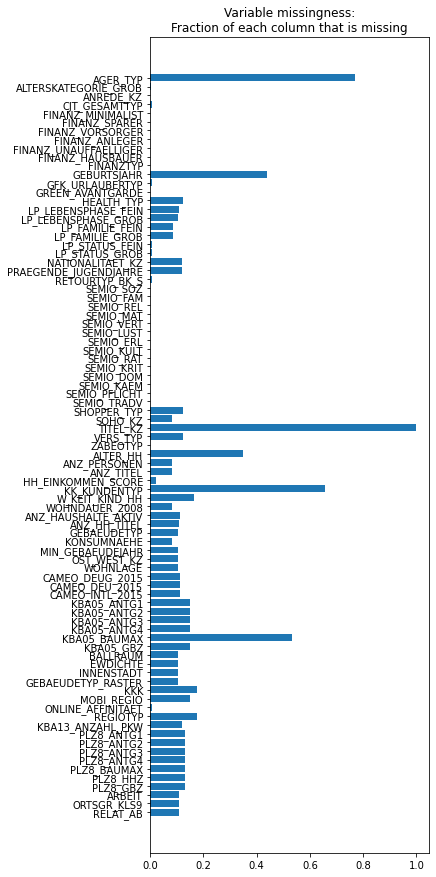

In [13]:
plt.figure(figsize=(5,15))
plt.barh(nan_check.variable,nan_check.nan_frac)
plt.gca().invert_yaxis()
plt.title('Variable missingness:\nFraction of each column that is missing');

In [14]:
print('Here we see that six variables have more than 30% missing values. \n\
We will drop these rows into main clustering routine. \nThe variables are:')
outlier_variables = list(nan_check[nan_check['nan_frac'] > 0.3]['variable'].values)
print(outlier_variables)

Here we see that six variables have more than 30% missing values. 
We will drop these rows into main clustering routine. 
The variables are:
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [15]:
variables_with_missing = list(nan_check[nan_check['nan_frac'] > 0]['variable'])

In [16]:
%%time
azdias_nan_corr = az0.filter(items = variables_with_missing).isnull().corr()

CPU times: user 8.95 s, sys: 918 ms, total: 9.87 s
Wall time: 9.93 s


CPU times: user 639 ms, sys: 319 ms, total: 958 ms
Wall time: 958 ms


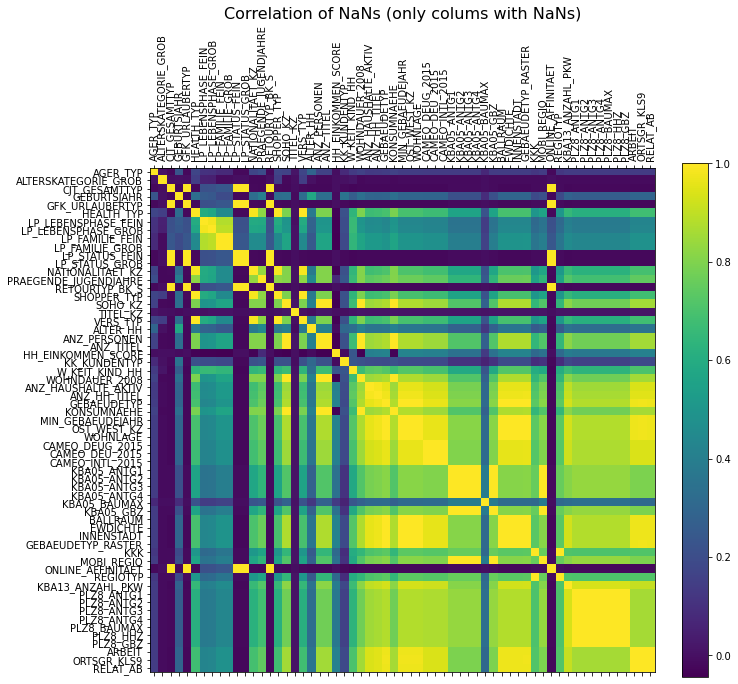

In [17]:
%%time
fig, ax = plt.subplots(figsize = (10,10));
c_plot = ax.matshow(azdias_nan_corr);
plt.xticks(range(0,len(azdias_nan_corr)), az0.filter(items = variables_with_missing).columns,rotation = 90)
plt.yticks(range(0,len(azdias_nan_corr)), az0.filter(items = variables_with_missing).columns)
plt.title('Correlation of NaNs (only colums with NaNs)',size = 16);
fig.colorbar(c_plot,fraction=0.046);

Here we see a number of groups with perfectly correlated missing levels, about two thirds of the variables with missing levels exhibit high correlation with each other (e.g. > 90% correlated)

In [172]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.



In [173]:
# Investigate patterns in the amount of missing data in each column.



In [174]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)



#### Discussion 1.1.2: Assess Missing Data in Each Column

 - Here we see a number of groups with perfectly correlated missing levels, about two thirds of the variables with missing levels exhibit high correlation with each other (e.g. > 90% correlated).  

 - Six outlier variables (['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']) identified as having more than 30% missingness. These will be dropped by the function 'filter_rows_and_cols_with_lots_of_nas()'.  

 - Apart from the six outlier variables, most variables have fewer than 10% NaNs.  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
row_missingness = pd.DataFrame(data = {'nan_frac' : np.array(az0.copy().isnull()\
                                           .sum(axis =1)\
                                           /az0.shape[1])
                                      })

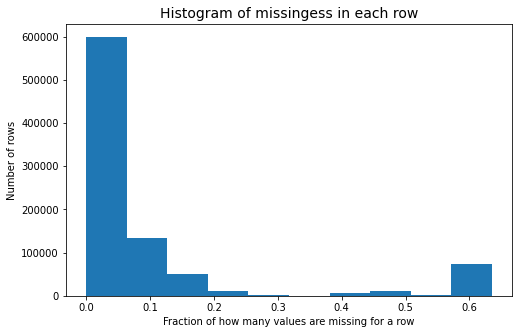

In [19]:
plt.figure(figsize = (8,5))
plt.hist(row_missingness)
plt.xlabel('Fraction of how many values are missing for a row')
plt.ylabel('Number of rows')
plt.title('Histogram of missingess in each row', size = 14);

In [22]:
def filter_rows_and_cols_with_lots_of_nas(df,row_threshold):
    
    df_ = df.copy()
    
    df_ = df_.drop(outlier_variables,axis = 1)
    
    row_missingness = pd.DataFrame(data = {'nan_frac' : np.array(df_.isnull().sum(axis =1)/df_.shape[1])})
    
    row_missingness.loc[row_missingness['nan_frac'] >  row_threshold,'outlier'] = 1
    row_missingness.loc[row_missingness['nan_frac'] <= row_threshold,'outlier'] = 0
    df_outliers = df_[row_missingness['outlier'] == 1]
    df_regulars = df_[row_missingness['outlier'] == 0]
    
    return df_outliers, df_regulars

In [24]:
### Divide into two sets
az1_outliers, az1_regulars = filter_rows_and_cols_with_lots_of_nas(df=az0, row_threshold = 0.3)

In [25]:
print('Original number of rows:   '+str(len(az0)))
print('Number of outlier rows:    '+str(len(az1_outliers))+' (i.e. '+ str(round(len(az1_outliers)/len(az0)*100,1)) +'%)')
print('Row count below threshold: '+str(len(az1_regulars))+' (i.e. '+ str(round(len(az1_regulars)/len(az0)*100,1)) +'%)')

Original number of rows:   891221
Number of outlier rows:    93384 (i.e. 10.5%)
Row count below threshold: 797837 (i.e. 89.5%)


In [26]:
def select_non_na_col_sample(df,ncols):
    df_out = df.drop(columns= df.loc[:,df.columns.isin(variables_with_missing)].columns)\
               .sample(n=ncols,axis='columns',random_state = 123)
    return df_out

In [27]:
az1_outliers_5_samp = select_non_na_col_sample(az1_outliers,5)
az1_regulars_5_samp = select_non_na_col_sample(az1_regulars,5)

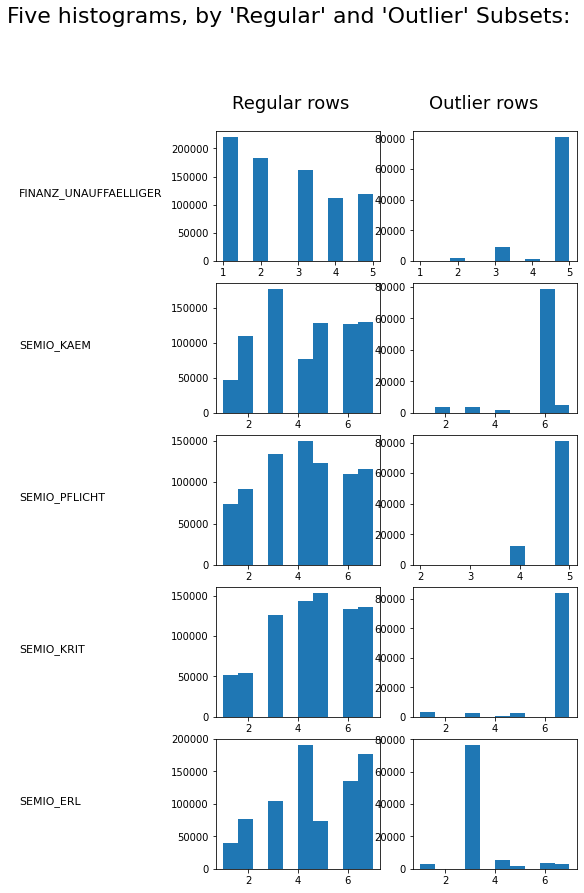

In [28]:
plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(5+1,2+1,height_ratios = [0.01, 1,1,1,1,1])
plt.suptitle('Five histograms, by \'Regular\' and \'Outlier\' Subsets:', size = 22)

axs = {}

axs[0,1] = plt.subplot(gs[0,1])
axs[0,1].set_axis_off()
axs[0,1].text(0.1, 0, 'Regular rows',size = 18)

axs[0,2] = plt.subplot(gs[0,2])
axs[0,2].set_axis_off()
axs[0,2].text(0.1, 0, 'Outlier rows',size = 18)

for i, var in enumerate(az1_outliers_5_samp.columns.values):
    
    axs[i+1,0] = plt.subplot(gs[i+1,0])
    axs[i+1,0].set_axis_off()
    axs[i+1,0].text(0, 0.5, var,size = 11)
    
    axs[i+1,1] = plt.subplot(gs[i+1,1])
    plt.hist(az1_regulars_5_samp[var])
    
    axs[i+1,2] = plt.subplot(gs[i+1,2])
    plt.hist(az1_outliers_5_samp[var])



#### Discussion 1.1.3: Assess Missing Data in Each Row

Here we see distributions for five randomly selected colums that don\'t have null values. They show very different shapes if the row has missing values.  
i.e the values in columns without missing values for a particular row are highly correlated to whether they have missing values elsewhere. This indicates missingness is not random, and may be an important feature/differentiator.  
--> In summary, rows with missing values have very different distributions even in columns that are non-missing.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
print(feat_info.type.unique())

['categorical' 'ordinal' 'numeric' 'mixed' 'interval']


In [34]:
vars_categ = feat_info[feat_info['type'] == 'categorical'].attribute
vars_ordin = feat_info[feat_info['type'] == 'ordinal'].attribute
vars_numer = feat_info[feat_info['type'] == 'numeric'].attribute
vars_mixed = feat_info[feat_info['type'] == 'mixed'].attribute
vars_inter = feat_info[feat_info['type'] == 'interval'].attribute

In [36]:
### Print number of features by each variable type
feat_info.groupby('type').size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [38]:
### Infer treatment needed for each variable

In [39]:
def summarise_catagoric_treatment_needed(df, verbose = False):
    
    df_ = df.copy()
    
    dict_ = {}

    ### Create dictionary
    for var in df_.loc[:,df_.columns.isin(feat_info[feat_info['type'] == 'categorical'].attribute)].columns:
        # Binary categoric
        if len(df_[var].dropna().unique()) == 2:
            if type(np.array(df_[var].dropna())[0]) == str:
                cat_type = 'binary_str'
            else:
                cat_type = 'binary_num'
        # Multi-level categoric
        if len(df_[var].dropna().unique()) > 2:
            cat_type = 'multi'

        dict_[var] = cat_type
        
    ### Convert to dataframe    
    vars_categ_types = pd.DataFrame.from_dict(dict_,orient='index').reset_index()\
                     .rename(columns = {'index':'var',0:'type'})
    vars_categ_types['need to re-encode'] = False
    vars_categ_types.loc[vars_categ_types['type'].isin(['binary_str','multi']),vars_categ_types.columns == 'need to re-encode'] = True
    if verbose: print(vars_categ_types)
        
    return vars_categ_types

In [40]:
vars_categ_types = summarise_catagoric_treatment_needed(df = az1_regulars, verbose = False)

In [41]:
### For binary variables encoded as strings
def re_encode_binary_str(df,vars_categ_types):
    
    df_ = df.copy()

    for var in np.array(vars_categ_types[vars_categ_types['type'] == 'binary_str']['var']):

        level_to_encode = np.array(df_[var].dropna())[0]
        var_label_encod_name = var + '_is_' + level_to_encode

        df_[var_label_encod_name] = df_[var].apply(lambda x: 1 if x == level_to_encode else 0)
        df_ = df_.drop(var,axis = 1)

        return df_

In [42]:
### For multi-level variables (Pandas 'get_dummies' is simpler than sklearn.preprocessing.onehotencoding)
def re_encode_multi(df,vars_categ_types):
    
    df_ = df.copy()
    
    for var in np.array(vars_categ_types[vars_categ_types['type'] == 'multi']['var']):
    
        df_ = pd.concat([df_.drop(var,axis = 1),
                         pd.get_dummies(df_[var],
                                        prefix=var,
                                        prefix_sep="_",
                                        drop_first=True,
                                        dummy_na = True)],
                         axis = 1)
    return df_

In [43]:
az2 = re_encode_binary_str(az1_regulars,vars_categ_types)
az2 = re_encode_multi(az2,vars_categ_types)

In [44]:
print('Number of columns BEFORE re-encoding: '+str(len(az1_regulars.columns)))
print('Number of columns AFTER  re-encoding: '+str(len(az2.columns)))

Number of columns BEFORE re-encoding: 79
Number of columns AFTER  re-encoding: 194


In [45]:
### Record how many colums are used to represent the variable after one-hot encoding
def record_number_of_level_after_reencoding_categorics(df_sum, df):
    df_sum['Num_Cols_After_re-encoding'] = 'Not re-encoded'
    for var in np.array(df_sum[df_sum['need to re-encode'] == True]['var']):
        count_after = len(df.filter(like=var).columns)
        df_sum.loc[df_sum['var'] == var, df_sum.columns == 'Num_Cols_After_re-encoding'] = count_after
    return df_sum

In [46]:
vars_categ_types = record_number_of_level_after_reencoding_categorics(vars_categ_types,az2)

In [47]:
var_list_catg_binary_num = list(vars_categ_types[vars_categ_types['type'] == 'binary_num']['var'])
var_list_catg_binary_str = list(vars_categ_types[vars_categ_types['type'] == 'binary_str']['var'])
var_list_catg_multi      = list(vars_categ_types[vars_categ_types['type'] == 'multi']['var'])

In [48]:
print('There were ' + str(len(var_list_catg_binary_num)) + \
      ' binary numeric categoric variables that did not need to be re-encoded.')
print('These are: '+ ", ".join(var_list_catg_binary_num)+'\n')

print('There was ' + str(len(var_list_catg_binary_str)) + \
      ' binary string categoric variable that was re-encoded.')
print('This was: '+ " ".join(var_list_catg_binary_str)+'\n')
    
print('There were ' + str(len(var_list_catg_multi)) + \
      ' multi-level categoric variables that was re-encoded.')
print('These are: '+ ", ".join(var_list_catg_multi))
    
# Categoric re-encoding of variables with n levels were re-encoded to n-1 variables.
    


There were 4 binary numeric categoric variables that did not need to be re-encoded.
These are: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP

There was 1 binary string categoric variable that was re-encoded.
This was: OST_WEST_KZ

There were 13 multi-level categoric variables that was re-encoded.
These are: CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015


The table below shows that column expansion for each variable from categoric variable re-encoding:

In [49]:
vars_categ_types

var        type  need to re-encode Num_Cols_After_re-encoding
0          ANREDE_KZ  binary_num              False             Not re-encoded
1      CJT_GESAMTTYP       multi               True                          6
2          FINANZTYP       multi               True                          6
3    GFK_URLAUBERTYP       multi               True                         12
4   GREEN_AVANTGARDE  binary_num              False             Not re-encoded
5    LP_FAMILIE_FEIN       multi               True                         11
6    LP_FAMILIE_GROB       multi               True                          5
7     LP_STATUS_FEIN       multi               True                         10
8     LP_STATUS_GROB       multi               True                          5
9   NATIONALITAET_KZ       multi               True                          3
10       SHOPPER_TYP       multi               True                          4
11           SOHO_KZ  binary_num              False             Not re-encoded
12          VERS_TYP  binary_num              False             Not re-encoded
13          ZABEOTYP       multi               True                          6
14       GEBAEUDETYP       multi               True                          8
15       OST_WEST_KZ  binary_str               True                          1
16   CAMEO_DEUG_2015       multi               True                          9
17    CAMEO_DEU_2015       multi               True                         44

#### Discussion 1.2.1: Re-Encode Categorical Features

 - From table above we see 14 variables were re-encoded and four categoric variables were not re-encoded.
 - Colum 'Num_Cols_After_re-encoding' shows how many columns result after categoric one-hot-encoding.  
 - Re-encoding led to increase from 79 to 194 columns.
 - All variables were kept.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

**Process PRAEGENDE_JUGENDJAHRE variable:**

Original dictionary:

In [50]:
### 1.18. PRAEGENDE_JUGENDJAHRE
# Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# - -1: unknown
# -  0: unknown
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)

In [51]:
def clean_PRAEGENDE_JUGENDJAHRE(df):
    
    df_ = df.copy()
    
    ### Extract mainstream (vs Non-AvanteGarde) variable
    Mainstream_list = [1,3,5,8,10,12,14]
    df_['PRAEGENDE_JUGENDJAHRE_Mainstream'] = 0
    df_.loc[pd.isnull(df_['PRAEGENDE_JUGENDJAHRE']),df_.columns == 'PRAEGENDE_JUGENDJAHRE_Mainstream'] = None
    df_.loc[df['PRAEGENDE_JUGENDJAHRE'].isin(Mainstream_list),df_.columns == 'PRAEGENDE_JUGENDJAHRE_Mainstream'] = 1

    ### Extract decade variable
    Year_list = pd.DataFrame(data = {'PRAEGENDE_JUGENDJAHRE'        : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                                     'PRAEGENDE_JUGENDJAHRE_decade' : [40,40,50,50,60,60,60,70,70,80,80,80,80,90,90]})
    df_ = pd.merge(df,Year_list,how = 'left', on = 'PRAEGENDE_JUGENDJAHRE')

    ### Drop original variable, and thus east-west information (not separable)
    df_ = df_.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    
    return df_

In [52]:
az3 = clean_PRAEGENDE_JUGENDJAHRE(az2)

**Process CAMEO_INTL_2015 variable:**

Original dictionary:

In [53]:
### 4.3. CAMEO_INTL_2015
# German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown

In [54]:
### Separate Wealth/LifeStyle indicators and convert to float type (whilst also preserving NaN levels)
def clean_CAMEO_INTL_2015(df):
    
    df_ = df.copy()
    
    df_['CAMEO_INTL_2015_Wealth']     = df_['CAMEO_INTL_2015'].str[0:1].astype('float')
    df_['CAMEO_INTL_2015_Life_Stage'] = df_['CAMEO_INTL_2015'].str[1:2].astype('float')
    df_ = df_.drop('CAMEO_INTL_2015', axis = 1)
    
    return df_

In [55]:
az3 = clean_CAMEO_INTL_2015(az3)

#### Discussion 1.2.2: Engineer Mixed-Type Features

 - PRAEGENDE_JUGENDJAHRE was encoded to two new variables whilst preserving NaN levels for subsequent imputation, the original variable is dropped.  
 - CAMEO_INTL_2015 was encoded to two new variables, the original is dropped and NaN is also preserved (again for subsequent imputtion).

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
dtypes = az3.dtypes.reset_index().rename(columns={'index':'var', 0:'dtype'})

In [57]:
dtypes.groupby(['dtype']).size()

dtype
uint8      128
int64        1
float64     66
dtype: int64

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [63]:
def clean_data(df_input = azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    print('Step1: Encoding missing values as NaN')
    az0 = missing_value_encoding(df = df_input, verbose = False)
    
    print('Step2: Removing rows when more than 30% of their values are NaN')
    az1_outliers, az1_regulars = filter_rows_and_cols_with_lots_of_nas(df=az0, row_threshold = 0.3)
    
    print('Step3: Summarising treatment of categoric variables that is needed')
    vars_categ_types = summarise_catagoric_treatment_needed(df = az1_regulars, verbose = False)
    
    print('Step4: Re-encoding categoric variables')
    az2 = re_encode_binary_str(az1_regulars,vars_categ_types)
    az2 = re_encode_multi(az2,vars_categ_types)
    
    print('Step5: Engineering mixed-type variables')
    az3 = clean_PRAEGENDE_JUGENDJAHRE(az2)
    az3 = clean_CAMEO_INTL_2015(az3)    
    
    return az3

In [64]:
%%time 
df_azdi_1 = clean_data(df_input = azdias)

Step1: Encoding missing values as NaN
Step2: Removing rows when more than 30% of their values are NaN
Step3: Summarising treatment of categoric variables that is needed
Step4: Re-encoding categoric variables
Step5: Engineering mixed-type variables
CPU times: user 18.2 s, sys: 13 s, total: 31.2 s
Wall time: 31.7 s


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [65]:
### Function replaces NaNs with mean values, and flags records that have been imputed 
### ..so NaN imputation itself becomes a feature

def nan_flagging_and_mean_encoding(df_):
    df = df_.copy()
    
    print('Number of columns before: '+ str(len(df.columns)))
    
    for var in df.columns:
        df[var+'_NAN_flag'] = 0
        df.loc[pd.isnull(df[var]),df.columns == var+'_NAN_flag'] = 1
        df.loc[pd.isnull(df[var]),df.columns == var            ] = df[var].mean()
        if sum(df[var+'_NAN_flag']) == 0:
            df = df.drop(var+'_NAN_flag',axis = 1)
            
    print('Number of columns after:  '+ str(len(df.columns)))
    
    return df

In [66]:
%%time
df_azdi_2 = nan_flagging_and_mean_encoding(df_azdi_1)

Number of columns before: 195
Number of columns after:  232
CPU times: user 2min 50s, sys: 2min 27s, total: 5min 18s
Wall time: 5min 19s


In [67]:
print('Number of rows BEFORE dropping NaNs: '+str(df_azdi_2.shape[0]))
print('Number of rows AFTER  dropping NaNs: '+str(df_azdi_2.dropna().shape[0]))
print('After NAs have been imputed, there are no NaNs left to drop.')

Number of rows BEFORE dropping NaNs: 797837
Number of rows AFTER  dropping NaNs: 797837
After NAs have been imputed, there are no NaNs left to drop.


In [68]:
### Standard scaling

In [69]:
ss = StandardScaler()

In [70]:
ss.fit(np.array(df_azdi_2));

In [71]:
df_azdi_3 = pd.DataFrame(ss.transform(np.array(df_azdi_2.dropna())), columns=df_azdi_2.columns)

In [72]:
### Check example variable distribution before and after scaling

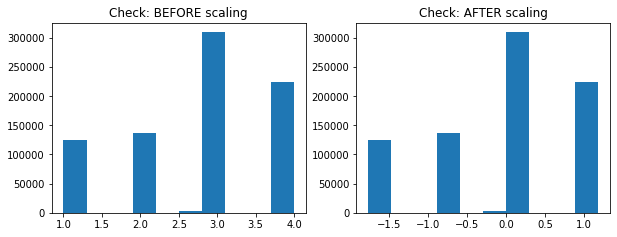

In [120]:
fig = plt.figure(figsize = [10,3.5])
gs = gridspec.GridSpec(nrows = 1, ncols = 2)

ax1 = plt.subplot(gs[0,0])
plt.hist(df_azdi_2[df_azdi_2.columns[0]])
plt.title('Check: BEFORE scaling')

ax2 = plt.subplot(gs[0,1])
plt.hist(df_azdi_3[df_azdi_3.columns[0]])
plt.title('Check: AFTER scaling');

### Discussion 2.1: Apply Feature Scaling

NaNs were mean-encoded prior to standard scaling such that after standardisation, NaNs would take a value of 0. At the same time NaN mean encoding was captured as an additional feature, thus taking number of variables from 195 to 232.

The side-by-side plots show x-axis distribution of (randomly selected) variable has shifted to have mean ~0 and sstandard deviation ~1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [75]:
### Set high number initially
n_comp = 50

In [76]:
pca = PCA(n_components=n_comp, random_state=1)

In [77]:
pca = pca.fit(df_azdi_3)

In [78]:
df_exp_var = pd.DataFrame(data = {
    'pca_num'            : [i for i in range(0,n_comp)],
    'pca_exp_var'        : pca.explained_variance_ratio_,
    'pca_exp_var_cumsum' : np.cumsum(pca.explained_variance_ratio_)
    })

50.0% of variance is explained by the first 30.0 principle components.


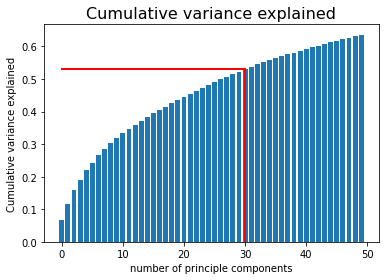

In [81]:
### Describe selected thrshold
cum_sum_thresh  = 0.53
pca_thesh_count = df_exp_var[df_exp_var['pca_exp_var_cumsum']>cum_sum_thresh].iloc[0][0]
print(str(round(cum_sum_thresh*100,-1))+'% of variance is explained by the first '\
      +str(pca_thesh_count)+' principle components.')

### Plot
plt.bar(x = df_exp_var.pca_num, height = df_exp_var.pca_exp_var_cumsum)
plt.plot([0, 30],[0.53, 0.53] , 'k-', lw=2,color = 'red')
plt.plot([30, 30],[0, 0.53] , 'k-', lw=2,color = 'red')
plt.xlabel('number of principle components')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained', size = 16);

In [238]:
### Create dataframe of n-selected principle components

In [83]:
%%time
pca_30 = PCA(n_components=30,random_state=1)
pca_30 = pca_30.fit(df_azdi_3)
df_demog_30  = pd.DataFrame(pca_30.transform(df_azdi_3),
                            columns=['pca_'+str(i).zfill(2) for i in range(0,30)])

CPU times: user 47.5 s, sys: 8.88 s, total: 56.4 s
Wall time: 21.1 s


In [84]:
df_demog_30.shape

(797837, 30)

In [85]:
### Preview the transformed data
df_demog_30.head(5)

pca_00    pca_01    pca_02    pca_03    pca_04    pca_05    pca_06  \
0 -4.071677  2.905881 -2.823007  0.063586 -2.878249  1.589621 -0.597279   
1 -0.056826 -0.479243 -0.939499  0.267778 -2.957422  1.233729 -0.787021   
2  4.325644 -2.047350  1.115483  5.554663 -0.005725 -3.125440 -1.275146   
3 -0.397175 -1.174319 -0.728425 -1.833125  2.937312  0.842565  2.313685   
4  0.133814 -0.515835 -1.495196  0.278603 -1.303695 -1.451839 -3.536129   

     pca_07    pca_08    pca_09  ...    pca_20    pca_21    pca_22    pca_23  \
0  0.376604 -0.071572 -0.327573  ... -1.010176  0.060488 -2.597516  2.744260   
1  0.906338 -3.604698 -0.199392  ...  3.390296  0.068760  1.002562 -1.279315   
2 -1.981934 -1.204555  1.982889  ... -3.415673 -1.134348 -1.850473 -4.375904   
3  0.660034  2.382786 -0.668128  ...  0.283206 -1.105403 -0.580106 -0.787329   
4  0.713659 -0.782467 -1.128402  ... -1.070014  0.828802 -1.134975  1.278549   

     pca_24    pca_25    pca_26    pca_27    pca_28    pca_29  
0  4.911094  0.926851  2.201081 -1.531462 -0.435694 -0.829605  
1 -0.893541  1.312955 -0.248782  1.137257 -0.444835 -0.683037  
2 -0.487337  1.020868  1.621415  1.954567 -1.366677  0.075916  
3 -0.638691  0.826409 -1.525206  1.928075 -0.918221 -1.937094  
4 -0.794555  0.324157  0.136310  1.269487  1.124632  1.387144  

[5 rows x 30 columns]

### Discussion 2.2: Perform Dimensionality Reduction

 - Here we can see that 30 variables are able to explain 53% of total variance.  
 - Subsequent analysis will focus on using only the first 30 PCAs (e.g. in clustering).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [86]:
def print_pca_var_weights(pca_to_use,pca_no,cols):
    dp1 = pd.DataFrame(data = pca_to_use.components_,columns=cols)
    dp1 = dp1.transpose()
    dp1.columns = ["pca_"+str(i).zfill(2) for i in dp1.columns]
    dp2 = dp1.loc[:,dp1.columns == pca_no].rename(columns = {pca_no:'weight'})
    dp2['weight_abs_sort_desc'] = np.abs(dp2['weight'])
    dp2 = dp2.sort_values('weight_abs_sort_desc',ascending = False)\
             .reset_index()\
             .rename(columns = {'index':'variable'})\
             .reset_index()\
             .drop('weight_abs_sort_desc',axis = 1)
    dp2.insert(1,'var_imp_rank', dp2['index']+1)
    dp2 = dp2.iloc[0:10].drop('index',axis = 1)
    
    
    # set columns
    index_ = pd.MultiIndex.from_tuples(list([["","var_imp_rank"],[pca_no,'variable'],[pca_no,'weight']]))
    dp2 = pd.DataFrame(data = np.array(dp2),columns =index_)
    
    return dp2

In [87]:
### Calculate the pca summaries

pca_sum_1 = print_pca_var_weights(pca_to_use = pca_30,pca_no = 'pca_01',cols = df_azdi_3.columns)
pca_sum_2 = print_pca_var_weights(pca_to_use = pca_30,pca_no = 'pca_02',cols = df_azdi_3.columns)
pca_sum_3 = print_pca_var_weights(pca_to_use = pca_30,pca_no = 'pca_03',cols = df_azdi_3.columns)
pca_sum_4 = print_pca_var_weights(pca_to_use = pca_30,pca_no = 'pca_04',cols = df_azdi_3.columns)
pca_sum_5 = print_pca_var_weights(pca_to_use = pca_30,pca_no = 'pca_05',cols = df_azdi_3.columns)

In [ ]:
### Print each pca summary one after another

In [88]:
pca_sum_1

pca_01          
  var_imp_rank                      variable    weight
0            1  PRAEGENDE_JUGENDJAHRE_decade  0.189546
1            2                 FINANZ_SPARER   0.18592
2            3         FINANZ_UNAUFFAELLIGER  0.185158
3            4          ALTERSKATEGORIE_GROB -0.181139
4            5              FINANZ_VORSORGER -0.179452
5            6           MOBI_REGIO_NAN_flag  0.169912
6            7          KBA05_ANTG1_NAN_flag  0.169912
7            8            KBA05_GBZ_NAN_flag  0.169912
8            9          KBA05_ANTG4_NAN_flag  0.169912
9           10          KBA05_ANTG3_NAN_flag  0.169912

In [89]:
pca_sum_2

pca_02          
  var_imp_rank                      variable    weight
0            1           PLZ8_ANTG4_NAN_flag  0.189836
1            2             PLZ8_GBZ_NAN_flag  0.189836
2            3           PLZ8_ANTG2_NAN_flag  0.189836
3            4           PLZ8_ANTG3_NAN_flag  0.189836
4            5           PLZ8_ANTG1_NAN_flag  0.189836
5            6          PLZ8_BAUMAX_NAN_flag  0.189836
6            7             PLZ8_HHZ_NAN_flag  0.189836
7            8          ALTERSKATEGORIE_GROB  0.164883
8            9  PRAEGENDE_JUGENDJAHRE_decade -0.160637
9           10                     SEMIO_REL -0.157971

In [90]:
pca_sum_3

pca_03          
  var_imp_rank                      variable    weight
0            1           GFK_URLAUBERTYP_nan  0.298115
1            2             CJT_GESAMTTYP_nan  0.298115
2            3       RETOURTYP_BK_S_NAN_flag  0.298115
3            4            LP_STATUS_FEIN_nan  0.298115
4            5            LP_STATUS_GROB_nan  0.298115
5            6    ONLINE_AFFINITAET_NAN_flag  0.298115
6            7  LP_LEBENSPHASE_FEIN_NAN_flag  0.269084
7            8  LP_LEBENSPHASE_GROB_NAN_flag  0.267462
8            9           LP_FAMILIE_GROB_nan  0.243692
9           10           LP_FAMILIE_FEIN_nan  0.243692

### Discussion 2.3: Interpret Principal Components

 - First principle component focuses on age and financial status.  
 - Second principle component focuses on missingness of the measure of how many families live in single household. 
 - Third principle component focuses on work and social interests.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [91]:
### Delete old datasets to save RAM
# del az0, az1_outliers, az1_regulars, az2, az3

In [ ]:
### Test number of clusters to use

In [93]:
def plot_elbow(data):
    verbose = True

    k_max = 15
    avg_diff = np.zeros(k_max)

    for k in range(1, k_max+1):
        if verbose: print("k = "+ str(k))

        kmeans_ = KMeans(n_clusters = k)
        model_  = kmeans_.fit(data)
        labels_ = model_.predict(data)

        center_array_ = [list(model_.cluster_centers_[labels_[j]]) for j in range(0,len(labels_))] 

        distances_ = [np.linalg.norm(data[labels_ == j] - np.array(center_array_)[labels_ == j]) for j in range(0,max(labels_)+1)]

        avg_dist[k-1] = np.mean(distances_)

    fig = plt.figure()
    plt.plot(np.array(range(1,k_max+1)), avg_dist, marker = 'x', color = 'r')
    plt.xlabel('Number of clusters')
    plt.ylabel('Avg. distance to nearest cluster centre')
    plt.xticks(ticks=[i for i in range(1,k_max+1)])
    plt.title('Finding K: Kmeans Elbow Method');

k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10
k = 11
k = 12
k = 13
k = 14
k = 15
CPU times: user 26min 47s, sys: 2min 17s, total: 29min 4s
Wall time: 23min 57s


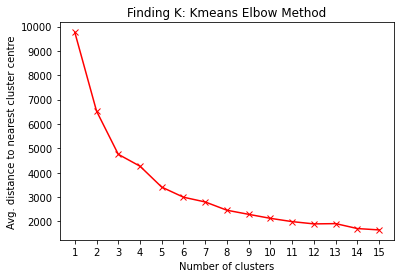

In [94]:
%%time
plot_elbow(df_demog_30)

In [ ]:
### Fit chosen number of clusters

In [96]:
%%time
kmeans_ = KMeans(n_clusters = 5)
model_  = kmeans_.fit(df_demog_30)
labels_popula = model_.predict(df_demog_30)

CPU times: user 53.5 s, sys: 4.71 s, total: 58.2 s
Wall time: 48.3 s


### Discussion 3.1: Apply Clustering to General Population

 - Plot shows in terms of average distance to cluster centres, we can see 'elbow' kink at k = 5 (whilst also another smaller kink at k = 3).
 - We select k = 5 although other methods could be used to further validate choice (such as silouhete method)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [97]:
### Load in customer data
custom = pd.read_csv(dir + 'Udacity_CUSTOMERS_Subset.csv',delimiter = ';')

In [99]:
%%time 
### Clean the customer data
df_cust_1 = clean_data(df_input = custom)

Step1: Encoding missing values as NaN
Step2: Removing rows when more than 30% of their values are NaN
Step3: Summarising treatment of categoric variables that is needed
Step4: Re-encoding categoric variables
Step5: Engineering mixed-type variables
CPU times: user 2.84 s, sys: 1.02 s, total: 3.86 s
Wall time: 3.86 s


In [101]:
%%time
### Impute NaNs and record imputation as new features
df_cust_2 = nan_flagging_and_mean_encoding(df_cust_1)

Number of columns before: 194
Number of columns after:  230
CPU times: user 27.8 s, sys: 23 s, total: 50.8 s
Wall time: 51.1 s


In [ ]:
### Add features and reorder/drop columns to exactly match demographics dataframe

In [102]:
dummy_cols = [col for col in df_azdi_3.columns if col not in df_cust_2.columns]
for i in dummy_cols:
    df_cust_2[dummy_cols] = 0
df_cust_2 = df_cust_2[df_azdi_3.columns]

In [103]:
%%time
### Standardise
df_cust_3 = pd.DataFrame(ss.transform(np.array(df_cust_2.dropna())), columns=df_cust_2.columns)

CPU times: user 564 ms, sys: 372 ms, total: 936 ms
Wall time: 935 ms


In [105]:
%%time
df_custo_30 = pd.DataFrame(pca_30.transform(df_cust_3),
                           columns=['pca_'+str(i).zfill(2) for i in range(0,30)])

CPU times: user 597 ms, sys: 114 ms, total: 711 ms
Wall time: 311 ms


In [106]:
### Check shape before predicting cluster labels on customer data.
df_custo_30.shape

(141690, 30)

In [107]:
%%time
labels_custom = model_.predict(df_custo_30)

CPU times: user 121 ms, sys: 38.3 ms, total: 159 ms
Wall time: 51 ms


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [108]:
### Calculate number of excluded records (adjusting for sampling used)
excluded_demog = len(azdias)-len(df_demog_30)
excluded_custo = len(custom)-len(df_custo_30)

In [109]:
### Summarise customers by cluster in each of the datasets
df_clus_demog = pd.concat([pd.DataFrame(data = {'labels_popula':labels_popula}).groupby(labels_popula).count()\
                            .reset_index().rename(columns={'index':'cluster'}),
                           pd.DataFrame(data = {'cluster'      :'excluded',
                                                'labels_popula':excluded_demog},
                                        index = [7])],
                           axis = 0)

df_clus_custo = pd.concat([pd.DataFrame(data = {'labels_custom':labels_custom}).groupby(labels_custom).count()\
                            .reset_index().rename(columns={'index':'cluster'}),
                           pd.DataFrame(data = {'cluster'      :'excluded',
                                                'labels_custom':excluded_custo},
                                        index = [7])],
                           axis = 0)

In [110]:
### Combine customers and demographic populations together, and add features.
df_clus = pd.merge(df_clus_demog,df_clus_custo,how='left',on='cluster')
df_clus['labels_popula_perc' ] = df_clus['labels_popula'] / sum(df_clus['labels_popula'])
df_clus['labels_custom_perc' ] = df_clus['labels_custom'] / sum(df_clus['labels_custom'])
df_clus['custom_popula_ratio'] = df_clus['labels_custom_perc' ] / df_clus['labels_popula_perc' ] -1

In [111]:
df_clus

cluster  labels_popula  labels_custom  labels_popula_perc  \
0         0         302782          92934            0.339738   
1         1         219581           3506            0.246382   
2         2          48962           6832            0.054938   
3         3           4666           3107            0.005236   
4         4         221846          35311            0.248924   
5  excluded          93384          49962            0.104782   

   labels_custom_perc  custom_popula_ratio  
0            0.484910             0.427304  
1            0.018294            -0.925751  
2            0.035648            -0.351125  
3            0.016212             2.096482  
4            0.184245            -0.259832  
5            0.260691             1.487937

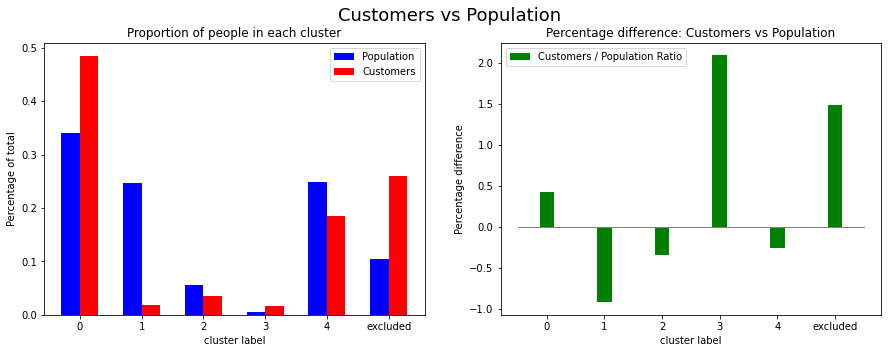

In [112]:
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1,2)
fig.suptitle('Customers vs Population',size = 18)

### Plot 1
ax1 = plt.subplot(gs[0,0])
ax1.bar(df_clus.index-0.15, df_clus['labels_popula_perc'], color = 'b', width = 0.3, label = 'Population')
ax1.bar(df_clus.index+0.15, df_clus['labels_custom_perc'], color = 'r', width = 0.3, label = 'Customers')
ax1.set_xticks(df_clus.index)
ax1.set_xticklabels(df_clus['cluster'].astype('str'))
plt.xlabel('cluster label');
plt.ylabel('Percentage of total');
plt.legend()
plt.title('Proportion of people in each cluster')

### Plot 2
ax2 = plt.subplot(gs[0,1])
ax2.bar(df_clus['cluster'].astype('str'), df_clus['custom_popula_ratio'], color = 'g', width = 0.25, label = 'Customers / Population Ratio')
plt.plot([-0.5, 5.5],[0, 0] , 'k-', lw=1,color = 'grey')
plt.xlabel('cluster label');
plt.ylabel('Percentage difference');
plt.legend();
plt.title('Percentage difference: Customers vs Population');

**Here we observe:**    
 - Cluster label 0 is over-represented in the customer population.  
 - Cluster label 1 is under-represented in the customer population.  
 - Cluster lable 3 is also over-represented, however volume of population & customers may be sensitive (i.e. not statistically significant.

In [261]:
model_.cluster_centers_.shape

(5, 30)

In [113]:
clus_weights_c0 = model_.cluster_centers_[0,:]
clus_weights_c1 = model_.cluster_centers_[1,:]

In [115]:
dv_interested = pd.DataFrame(data = 
                    {'var'                 : df_azdi_3.columns,
                     'value_interested_raw': ss.inverse_transform(pca_30.inverse_transform(clus_weights_c0)),
                     'value_interested_std':                      pca_30.inverse_transform(clus_weights_c0)})
dv_nointerest = pd.DataFrame(data = 
                    {'var'                 : df_azdi_3.columns,
                     'value_nointerest_raw': ss.inverse_transform(pca_30.inverse_transform(clus_weights_c1)),
                     'value_nointerest_std':                      pca_30.inverse_transform(clus_weights_c1)})
dv_both       = pd.merge(dv_interested,dv_nointerest,how='left',on='var')

In [116]:
dv_both_interested = pd.concat([dv_both.sort_values('value_interested_std').head(5),
                                dv_both.sort_values('value_interested_std').tail(5)],axis = 0).reset_index()
dv_both_nointerest = pd.concat([dv_both.sort_values('value_nointerest_std').head(5),
                                dv_both.sort_values('value_nointerest_std').tail(5)],axis = 0).reset_index()
                                

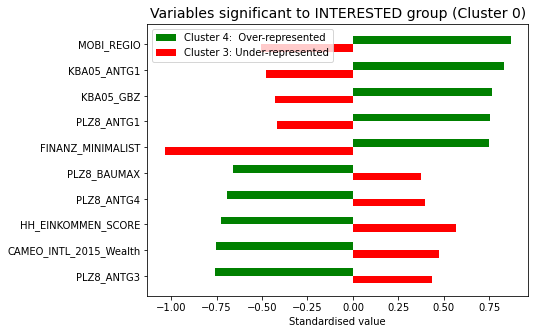

In [119]:
fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1,2)
# fig.suptitle('Customers vs Population',size = 18)

### Plot 1
ax1 = plt.subplot(gs[0,0])
ax1.barh(dv_both_interested.index+0.15, dv_both_interested['value_interested_std'], color = 'g', height = 0.3, label = 'Cluster 4:  Over-represented')
ax1.barh(dv_both_interested.index-0.15, dv_both_interested['value_nointerest_std'], color = 'r', height = 0.3, label = 'Cluster 3: Under-represented')
ax1.set_yticks(dv_both_interested.index)
ax1.set_yticklabels(dv_both_interested['var'])
plt.xlabel('Standardised value');
plt.legend()
plt.title('Variables significant to INTERESTED group (Cluster 0)',size = 14);

### Plot 2
# ax2 = plt.subplot(gs[0,1])
# ax2.barh(dv_both_nointerest.index+0.15, dv_both_nointerest['value_interested_std'], color = 'g', height = 0.3, label = 'Cluster 4:  Over-represented')
# ax2.barh(dv_both_nointerest.index-0.15, dv_both_nointerest['value_nointerest_std'], color = 'r', height = 0.3, label = 'Cluster 3: Under-represented')
# ax2.set_yticks(dv_both_nointerest.index)
# ax2.set_yticklabels(dv_both_nointerest['var'])
# plt.xlabel('Standardised value');
# plt.legend()
# plt.title('Variables significant to INTERESTED group (Cluster 3)');

In [118]:
dv_both_interested[['var','value_interested_std','value_nointerest_std','value_interested_raw','value_nointerest_raw']]

var  value_interested_std  value_nointerest_std  \
0              PLZ8_ANTG3             -0.757929              0.433845   
1  CAMEO_INTL_2015_Wealth             -0.751765              0.474230   
2      HH_EINKOMMEN_SCORE             -0.723769              0.568326   
3              PLZ8_ANTG4             -0.693972              0.399196   
4             PLZ8_BAUMAX             -0.661365              0.375266   
5       FINANZ_MINIMALIST              0.747446             -1.035198   
6              PLZ8_ANTG1              0.753275             -0.418739   
7               KBA05_GBZ              0.767166             -0.430139   
8             KBA05_ANTG1              0.833900             -0.477709   
9              MOBI_REGIO              0.867800             -0.503415   

   value_interested_raw  value_nointerest_raw  
0              0.858475              2.017267  
1              2.165455              3.954082  
2              3.295558              5.292059  
3              0.201923              0.985198  
4              0.992648              2.483673  
5              4.088509              1.632817  
6              2.974825              1.852255  
7              4.152697              2.601193  
8              2.635358              0.840595  
9              4.172087              2.262455

### Discussion 3.3: Compare Customer Data to Demographics Data

Analysing variables important to **over-represented** customer cluster (**cluster 0****):  
 -   MOBI_REGIO has the heighest significance (deviation from mean), the over-represented cluster centre signifies customers have 'lower movement' than aveage and the under-represented cluster.  
 -   KBA05_ANTG1 has 2nd heighest significance (deviation from mean), the over-represented cluster centre has fewer families per household than average and the under-represented cluster.  
     - PLZ8_ANTG3 result denotes similarly (so not discussed again).
 -   CAMEO_INTL_2015_Wealth indicates the over-represented cluster centre is younger and wealthier than average and the under-represented cluster. The typical famaily is 'Wealthy Households - Young Couples With Children'.  
 -   HH_EINKOMMEN_SCORE indicates the over-represented cluster centre has higher household net income than average or the under-represented cluster.  
 
The **under-represented** customer cluster (**cluster 1**) is oppositely ranked in all the above metrics, so qualatitively we expect under-represented cluster to resemble:
 - low income
 - High number of families in a single households
 - 'higher movement'

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.